## Long Short Term Memory (LSTM)

This is the notebook where I'll build the LSTM to predict future claims.

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [2]:
print(torch.cuda.get_device_name(0))
print(torch.cuda.is_available())

GeForce GTX 1080
True


Reading in our data

In [3]:
claims_df = pd.read_csv("claims.csv")
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

#change date column to datetime object
claims_df['ds'] = pd.to_datetime(claims_df['ds'])
train['ds'] = pd.to_datetime(train['ds'])
test['ds'] = pd.to_datetime(test['ds'])

A little refresher on what our claims data looks like

C:\Users\JT\Anaconda3\envs\deeplearning\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Claims by Month')

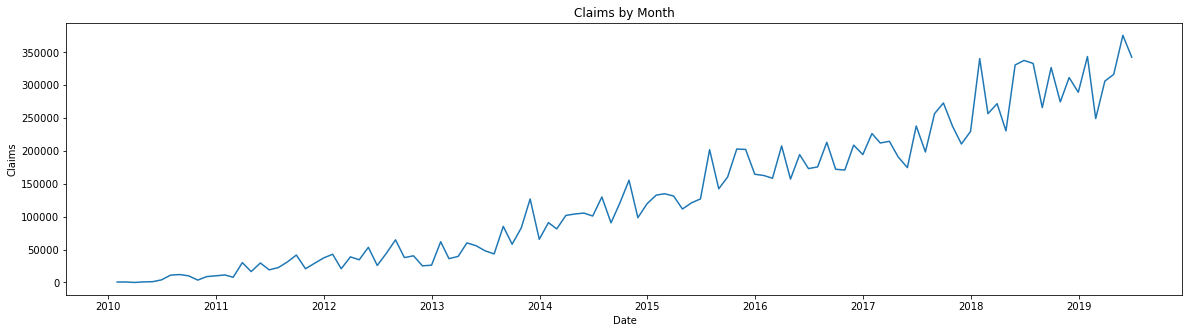

In [4]:
#aggregate claims to monthly
claims_monthly = claims_df.groupby(pd.Grouper(key='ds', freq='1M')).sum()

plt.figure(figsize=(20,5))
sns.lineplot(x = claims_monthly.index, y = claims_monthly['y'])
plt.xlabel('Date')
plt.ylabel('Claims')
plt.title('Claims by Month')

Now time for a little preprocessing and setting up the train and test sets. Let's try using just the claims data only first, then we can try to incorporate some exogeneous variables. I'm also going to aggregate to a monthly level to make my data continuous, but I will explore using the raw input later.

In [5]:
claims_monthly.drop('Unnamed: 0',axis = 1)

test_size = round(0.2*claims_monthly.shape[0])

train_data = pd.DataFrame(claims_monthly.iloc[:-test_size]['y'])
test_data = pd.DataFrame(claims_monthly.iloc[-test_size:]['y'])


print("Training Data Shape:", train_data.shape)
print("Test Data Shape:", test_data.shape)

Training Data Shape: (91, 1)
Test Data Shape: (23, 1)


Normalizing the data to make the network more stable and increase training speed.

In [6]:
scaler = MinMaxScaler()

train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

train_data = torch.cuda.FloatTensor(train_data).view(-1)
test_data = torch.cuda.FloatTensor(test_data).view(-1)

I'll be experimenting with modifying the sequence length for model input. I've read conflicting ideas on the sequence length and it varied from a very short length to hundreds or elements.

Using a sequence size of one can be thought of looking one month back to predict the next point.

### Model Building

In [7]:
#-----------------------------Model Build-------------------------------------
class LSTM(nn.Module):

    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):

        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        #Applies a multi-layer long short-term memory (LSTM) RNN to an input sequence
        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        #Applies a linear transformation to the incoming data
        self.linear = nn.Linear(hidden_layer_size, output_size)

        #initialize the hidden cell
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

I'm going to build a class that has some of the helper functions to train and evaluate our model.

In [30]:
class LSTM_helper:
    
    def __init__(self, model):
        
        self.model = model
        pass
        
    #method that will turn the training data into chunks of sequences    
    def create_seq(self, data, seq_len):
        seq_data = []
        L = len(data)
        for i in range(L-seq_len):
            #get the sequence of specified length
            train_seq = data[i:i+seq_len]
            
            #get the label, i.e. the observation after the seq length
            train_label = data[i+seq_len:i+seq_len+1]
            seq_data.append((train_seq ,train_label))

        return seq_data
#----------------------------------------Training--------------------------------------------
    def fit(self, train_data, seq_len, epochs=200, early_stopping = True, patience = 10):
        import EarlyStopping
         
        train_seq = self.create_seq(train_data, seq_len)
        
        self.model.cuda() #run model on GPU
        loss_function = nn.MSELoss()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)

        #training loop
        for i in range(epochs):
            for seq, labels in train_seq:
                optimizer.zero_grad()
                self.model.hidden_cell = (torch.zeros(1, 1, self.model.hidden_layer_size).cuda(),
                                torch.zeros(1, 1, self.model.hidden_layer_size).cuda())

                y_pred = self.model(seq)

                single_loss = loss_function(y_pred, labels)
                single_loss.backward()
                optimizer.step()
                
               
                    
            
#             if i%25 == 1:
#                 print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')
#                 print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,3), 'GB')
#                 print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,3), 'GB')
#                 print(' ')
#         print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')
#-----------------------------Model Evaluation----------------------------------------------------
    def predict(self, test_data, fut_pred):
        
        test_inputs = test_data.tolist()
        predictions = []
        
        self.model.eval()

        for i in range(fut_pred):
            seq = torch.cuda.FloatTensor(test_inputs)
            with torch.no_grad():
                model.hidden = (torch.zeros(1, 1, self.model.hidden_layer_size).cuda(),
                                torch.zeros(1, 1, self.model.hidden_layer_size).cuda())
                predictions.append(self.model(seq).item())
                test_inputs.append(self.model(seq).item())
                
        return predictions


In [79]:
def grid_search(hidden_layers, sequence_size, future_preds = 23):
        
    errors = []
        
    for i in hidden_layers:
        for j in sequence_size:
           
            model = LSTM(hidden_layer_size=i)
            model = LSTM_helper(model)
            model.fit(train_data, j, early_stopping = True, patience = 0) #early stopping/patience are not implemented
            
            test_raw = scaler.inverse_transform(test_data.cpu().numpy().reshape(-1,1))
            test_raw = pd.DataFrame(test_raw)



            LSTM_preds = model.predict(test_data, future_preds)

            LSTM_preds = scaler.inverse_transform(np.array(LSTM_preds).reshape(-1, 1))
            LSTM_preds = pd.DataFrame(LSTM_preds)
            
            RMSE = round(np.sqrt(np.square((test_raw - LSTM_preds).values)).sum(),0)
            errors.append((i,j,RMSE))
            
            print(i,j)
            
    return errors

In [ ]:
hidden_layers = [50, 100, 150, 200, 500]
sequence_size = [1,2,3,4,5,6,7,8,9,10]

#perform grid search of parameters
LSTM_model_errors = grid_search(hidden_layers, sequence_size)

#obtain all the errors from each tuple
errors = [x[2] for x in LSTM_model_errors]
#get the index location of the least error
min_location = np.argmin(errors)
print("Best Parameters:", LSTM_model_errors[min_location])

In [ ]:
models

In [ ]:
model = LSTM(hidden_layer_size=100)
model = LSTM_helper(model)

model.fit(train_data, 6,epochs=500, early_stopping = True, patience=10)


In [145]:
model = LSTM(hidden_layer_size=150)
model = LSTM_helper(model)
model.fit(train_data, 6, epochs=200, early_stopping = True, patience=10)




future_preds = 23

test_raw = scaler.inverse_transform(test_data.cpu().numpy().reshape(-1,1))
test_raw = pd.DataFrame(test_raw)



LSTM_preds = model.predict(test_data, future_preds)

LSTM_preds = scaler.inverse_transform(np.array(LSTM_preds).reshape(-1, 1))
LSTM_preds = pd.DataFrame(LSTM_preds)

epoch:   1 loss: 0.01712586
Allocated: 0.002 GB
Cached:    0.045 GB
 
epoch:  26 loss: 0.00334071
Allocated: 0.002 GB
Cached:    0.045 GB
 
epoch:  51 loss: 0.00235260
Allocated: 0.002 GB
Cached:    0.045 GB
 
epoch:  76 loss: 0.00239381
Allocated: 0.002 GB
Cached:    0.045 GB
 
epoch: 101 loss: 0.00236339
Allocated: 0.002 GB
Cached:    0.045 GB
 
epoch: 126 loss: 0.00195035
Allocated: 0.002 GB
Cached:    0.045 GB
 
epoch: 151 loss: 0.00223204
Allocated: 0.002 GB
Cached:    0.045 GB
 
epoch: 176 loss: 0.00004679
Allocated: 0.002 GB
Cached:    0.045 GB
 
epoch: 199 loss: 0.0001220047


Taking a look just at the test portion of our dataset

RMSE: 1378033.0


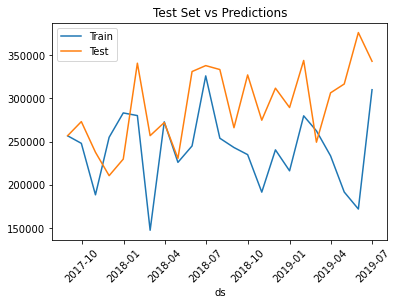

In [146]:
sns.lineplot(x = claims_monthly.index[-future_preds:], y = LSTM_preds[0].values)
sns.lineplot(x = claims_monthly.index[-future_preds:], y = test_raw[0].values)
plt.title("Test Set vs Predictions")
plt.legend(("Train", "Test"))
plt.xticks(rotation=45)

print("RMSE:", round(np.sqrt(np.square((test_raw - LSTM_preds).values)).sum(),0))

Here is a look of the the total data with the test performance included

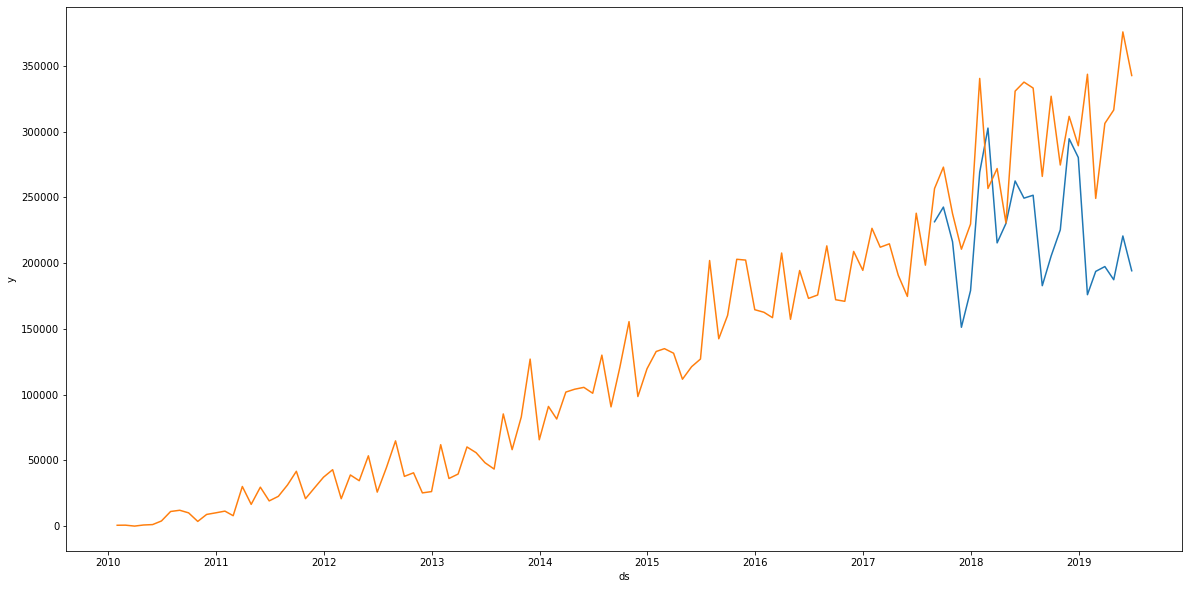

In [139]:
plt.figure(figsize=(20,10))
sns.lineplot(x = claims_monthly.index[-future_preds:], y=LSTM_preds[0].values)
sns.lineplot(x=claims_monthly.index, y = claims_monthly['y'])

### Including the Exogenous Variables